In [1]:
import yfinance as yf
import pandas as pd
import datetime
from statistics import mean
import matplotlib.pyplot as plt #pyplot package under the matplotlib package
import seaborn as sns
import math

plt.style.use("ggplot")
%matplotlib inline 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [331]:
ticker = yf.Ticker("tsla")

# set user input parameters

In [332]:
risk_free_rate = 0.0302

In [333]:
market_return_rate = 0.1

In [334]:
cap_growth = 1.15

In [335]:
current_year = "2022"

# Custom functions 

In [336]:
def clean_dataframe(frame):
    frame = frame.T.rename_axis('year').reset_index()
    frame["year"] = pd.DatetimeIndex(frame["year"]).year
    frame = frame.sort_values(by=['year'], ascending=False)
    frame.fillna(0, inplace=True)
    return frame

In [337]:
def get_DCF_value(history):
    #create empty growth list
    growth_history = []
    
    #calculate the growth between each year. add to the list
    for i in range(0,(len(ocf_history)-1)):
        growth = (history[i] - history[i+1]) / abs(history[i+1])    
        growth_history.append(growth)
    
    #get the average growth
    average_growth_rate = 1 + mean(growth_history)
    
    #for year 4-10, if average growth in year 1-3 is more than 15%, cap it at 15%
    if average_growth_rate > cap_growth: 
        average_growth_rate_cap = cap_growth
    else: 
        average_growth_rate_cap = average_growth_rate
        
    #project future cash flow (loop properly)
    future_value = []
    start_value = history[0]
    for i in range(1, 11):
        #for year 1 - 3, grow by average growth rate
        if i <= 3:
            value =  start_value * average_growth_rate
            future_value.append(value)
            start_value = value
        #for year 4-10, grow by cap growth rate
        elif i > 3:
            value =  start_value * average_growth_rate_cap
            future_value.append(value)
            start_value = value

    # convert future values into present value and sum them
    present_value = 0 

    for i in range(0, len(future_value)):
        value = future_value[i] / pow(wacc, (i+1))
        present_value += value
    
    #calculate present value per share
    fair_value = present_value/shares
    
    return fair_value

In [338]:
def get_cagr_DCF_value(history):
    #calculate CAGR
    base = history[0] / history[-1]
    power = 1/(len(history)-1)
    average_growth_rate = math.pow(base, power)

 #for year 4-10, if average growth in year 1-3 is more than 15%, cap it at 15%
    if average_growth_rate > cap_growth: 
        average_growth_rate_cap = cap_growth
    else: 
        average_growth_rate_cap = average_growth_rate
        
    #project future cash flow (loop properly)
    future_value = []
    start_value = history[0]
    for i in range(1, 11):
        #for year 1 - 3, grow by average growth rate
        if i <= 3:
            value =  start_value * average_growth_rate
            future_value.append(value)
            start_value = value
        #for year 4-10, grow by cap growth rate
        elif i > 3:
            value =  start_value * average_growth_rate_cap
            future_value.append(value)
            start_value = value

    # convert future values into present value and sum them
    present_value = 0 

    for i in range(0, len(future_value)):
        value = future_value[i] / pow(wacc, (i+1))
        present_value += value
    
    #calculate present value per share
    fair_value = present_value/shares
    
    return fair_value

In [339]:
def DCF_valuation_report(history):
    print("based on average year-on-year growth, intrinsic value is: {}".format(get_DCF_value(history)))
    try:
        print("based on CAGR, intrinsic value is: {}".format(get_cagr_DCF_value(history)))
    except ValueError: 
        print("CAGR growth calculation impossible as first year is negative value")

In [340]:
def perpetual_growth_valuation(history):
    growth_history = []
    
    #calculate the growth between each year. add to the list
    for i in range(0,(len(history)-1)):
        growth = (history[i] - history[i+1]) / abs(history[i+1])    
        growth_history.append(growth)

    #get the minimum growth
    min_growth_rate = 1 + min(growth_history)

    #bring to current year and then project for next year. assuming we missed this year's payment
    next_payment = history[0] * min_growth_rate * min_growth_rate 

    #apply formula
    valuation = next_payment / (wacc - min_growth_rate)
    return valuation

In [341]:
def plot_value(name, function, history, color):
    try:
        plt.barh([name], function(history), color=color)
    except ValueError: 
        pass

# Download fundementals

In [342]:
shares = ticker.info["sharesOutstanding"]
market_cap = ticker.info["marketCap"]
beta = ticker.info["beta"]
current_price = ticker.info['regularMarketPrice']

In [343]:
ticker.info["longBusinessSummary"]

'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits. It provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upgrades; and purchase financing and leasing services. This segment is also involved in the provision of non-warranty after-sales vehicle services, sale of used vehicles, retail merchandise, and vehicle insurance, as well as sale of products to third party customers; services for electric vehicles through its company-owned service locations, and Tesla mobile service technicians; and vehicle limited warranties and extended service plans. The Energy Generation and Storage segment engages in the design, manufac

# download and clean statements

In [344]:
## income statement 
IS = ticker.financials
IS = clean_dataframe(IS)

## balance sheet
BS = ticker.balance_sheet
BS = clean_dataframe(BS)

## cashflow statement
CF = ticker.cashflow
CF = clean_dataframe(CF)

## combined  dataset
df = pd.merge(IS, BS, on="year")
df = df.merge(CF, on= "year")
df["year"] = df['year'].astype(str)

In [345]:
#create total debt column
debt_types = ["Short Long Term Debt","Long Term Debt"] 
df["total_debt"] = 0

for i in debt_types:
    if (i in df.columns) == True:
        df["total_debt"]  += df[i]

In [346]:
df.columns

Index(['year', 'Research Development', 'Effect Of Accounting Charges',
       'Income Before Tax', 'Minority Interest_x', 'Net Income_x',
       'Selling General Administrative', 'Gross Profit', 'Ebit',
       'Operating Income', 'Other Operating Expenses', 'Interest Expense',
       'Extraordinary Items', 'Non Recurring', 'Other Items',
       'Income Tax Expense', 'Total Revenue', 'Total Operating Expenses',
       'Cost Of Revenue', 'Total Other Income Expense Net',
       'Discontinued Operations', 'Net Income From Continuing Ops',
       'Net Income Applicable To Common Shares', 'Intangible Assets',
       'Capital Surplus', 'Total Liab', 'Total Stockholder Equity',
       'Minority Interest_y', 'Other Current Liab', 'Total Assets',
       'Common Stock', 'Other Current Assets', 'Retained Earnings',
       'Other Liab', 'Good Will',
       'Gains Losses Not Affecting Retained Earnings', 'Other Assets', 'Cash',
       'Total Current Liabilities', 'Short Long Term Debt',
       'Oth

In [347]:
#free cash flow
df["FCF"]= df['Total Cash From Operating Activities'] + df['Capital Expenditures']

In [348]:
#Return on Equity
df["ROE"] = df["Net Income Applicable To Common Shares"] / df["Total Stockholder Equity"]

In [349]:
#current ratio
df['current_ratio'] = df['Total Current Assets'] / df['Total Current Liabilities']

In [350]:
#debt_to_equity
df["debt_to_equity"] = df["total_debt"] / df['Total Stockholder Equity']

# Charts 

In [351]:
axis = list(df["year"])
axis = sorted(axis)
axis

['2018', '2019', '2020', '2021']

## cashflows

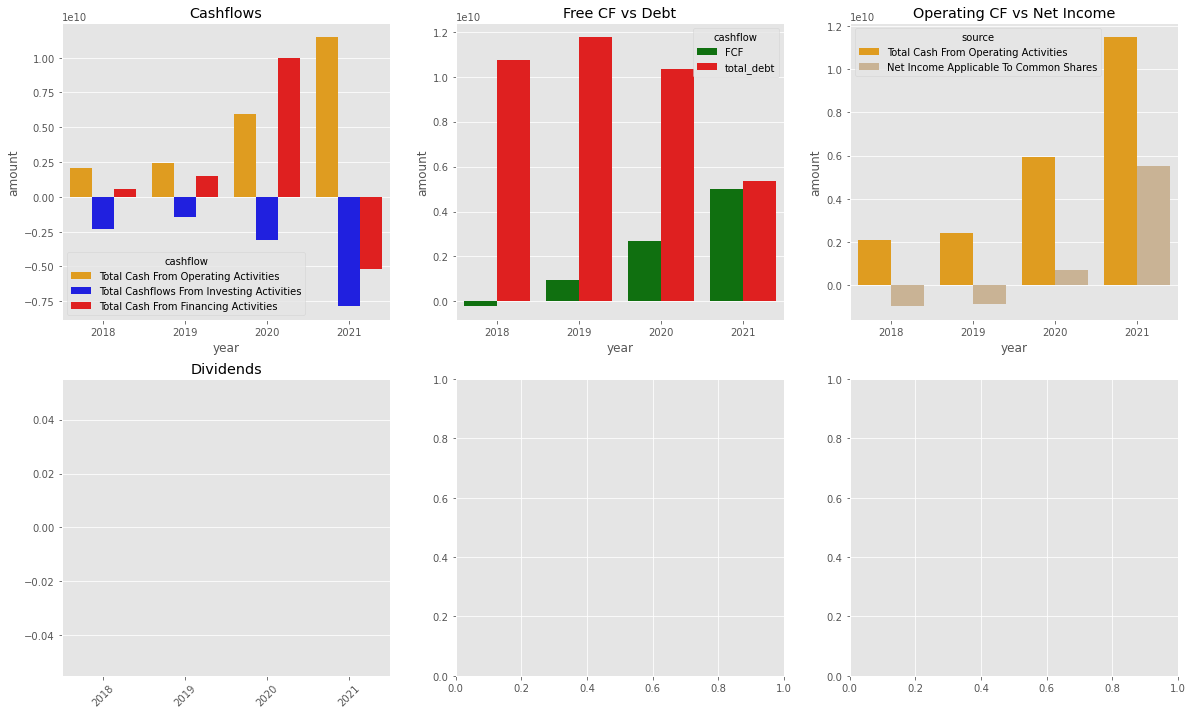

In [352]:
fig, axes = plt.subplots(2, 3,figsize=(20,12))


cashflow_df = df[["year","Total Cash From Operating Activities","Total Cashflows From Investing Activities", "Total Cash From Financing Activities"]]
cashflow_df = cashflow_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
sns.barplot("year", "amount", data=cashflow_df, hue = "cashflow", palette = ["orange", "blue", "red"], order=axis, ax=axes[0,0])
axes[0,0].set(title="Cashflows")

fcf_df = df[["year","FCF", "total_debt"]]
fcf_df = fcf_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
sns.barplot("year", "amount", data=fcf_df, hue = "cashflow", palette = ["green", "red"], order=axis, ax=axes[0,1])
axes[0,1].set(title="Free CF vs Debt")

cashflow_income= df[["year","Total Cash From Operating Activities",'Net Income Applicable To Common Shares']]
cashflow_income = cashflow_income.melt(id_vars="year",var_name="source",value_name="amount")
sns.barplot("year", "amount", data=cashflow_income, hue = "source", palette = ["orange", "tan"], order=axis,ax=axes[0,2])
axes[0,2].set(title="Operating CF vs Net Income")


#dividends already adjusted for stock split according to yahoo finance
dividend_history = ticker.actions
dividend_history = dividend_history.rename_axis('year').reset_index()
dividend_history["year"] = pd.DatetimeIndex(dividend_history["year"]).year
dividend_history = dividend_history[dividend_history["Stock Splits"]==0]
dividend_history = dividend_history[["year", "Dividends"]]
dividend_history = dividend_history.groupby("year").sum()

if len(dividend_history)>0:
    sns.barplot("year", "Dividends", data=dividend_history.reset_index(), color = "skyblue", ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set(title="Dividends")
else:
    sns.barplot(x = axis, y=[0] * len(axis) ,color = "skyblue", ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)   
    axes[1,0].set(title="Dividends")
    
#to add FCF/Debt in 2nd graph

## balancesheet

[Text(0.5, 1.0, 'Current Ratio and Debt to Equity')]

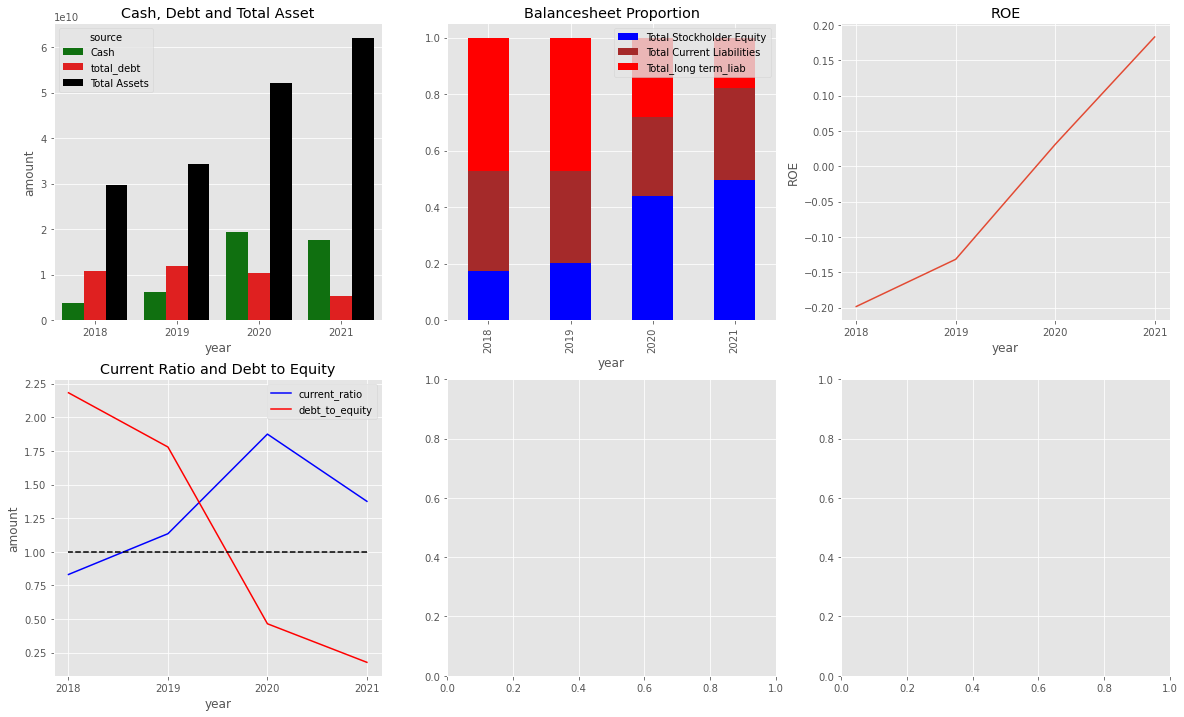

In [353]:
fig2, axes = plt.subplots(2, 3,figsize=(20,12))

balancesheet_prop= df[["year",'Cash', "total_debt", 'Total Assets']]
balancesheet_prop = balancesheet_prop.melt(id_vars="year",var_name="source",value_name="amount")
sns.barplot("year", "amount", data=balancesheet_prop, hue = "source", palette = ["green", "red", 'black', "black"], order=axis,ax=axes[0,0])
axes[0,0].set(title="Cash, Debt and Total Asset")

balancesheet_df = BS[["year",'Total Stockholder Equity','Total Current Liabilities','Total Liab']]
balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liab"] - balancesheet_df["Total Current Liabilities"] 
balancesheet_df.drop("Total Liab",axis="columns", inplace =True)
balancesheet_df = balancesheet_df.set_index("year").sort_index()
balancesheet_df = balancesheet_df.div(balancesheet_df.sum(axis=1), axis=0)
balancesheet_df.plot(kind='bar', stacked=True, color=['blue', 'brown', 'red'], ax=axes[0,1])
axes[0,1].set(title="Balancesheet Proportion")

sns.lineplot(df["year"], df["ROE"], ax=axes[0,2])
axes[0,2].invert_xaxis()
axes[0,2].set(title="ROE")

bs_ratio_df = df[["year","current_ratio", "debt_to_equity"]]
bs_ratio_df = bs_ratio_df.melt(id_vars="year",var_name="ratio",value_name="amount")
sns.lineplot(bs_ratio_df["year"], bs_ratio_df["amount"],hue=bs_ratio_df["ratio"], palette=["blue", "red"], ax=axes[1,0])
sns.lineplot(bs_ratio_df["year"], 1, color = "black", linestyle="--", ax=axes[1,0])
axes[1,0].invert_xaxis()
axes[1,0].set(title="Current Ratio and Debt to Equity")

# WACC calculations

## Extract lates year data

In [354]:
latest_year = df.iloc[0]

## debt section 

In [355]:
debt = latest_year["total_debt"]

total_wacc_value = debt + market_cap
total_wacc_value

debt_weight = debt/total_wacc_value

if abs(latest_year['Interest Expense']) != 0 and debt!=0:
    debt_cost = abs(latest_year['Interest Expense']) / debt
elif abs(latest_year['Interest Expense']) == 0 and debt==0:
    debt_cost = 0
elif abs(latest_year['Interest Expense']) != 0 and debt==0:
    debt_cost = 0

tax_rate = latest_year['Income Tax Expense'] / latest_year['Income Before Tax']

In [356]:
total_wacc_value

667318516032.0

## equity section

In [357]:
# beta = 1

In [358]:
beta

2.127855

In [359]:
equity_weight =  market_cap/total_wacc_value

equity_cost = risk_free_rate +  beta*(market_return_rate-risk_free_rate)
equity_cost

0.17872427899999999

## WACC

In [360]:
wacc = ((equity_weight * equity_cost) + (debt_weight * debt_cost * (1-tax_rate))) + 1
wacc

1.1777626134464962

# Discounted Growth Model

## a) Cashflow

In [361]:
# averge growth rate
ocf_history = list(df['Total Cash From Operating Activities'])
DCF_valuation_report(ocf_history)

based on average year-on-year growth, intrinsic value is: 119.74115777869838
based on CAGR, intrinsic value is: 104.42167607413792


## b) Income

In [362]:
ic_history = list(df['Net Income Applicable To Common Shares'])
DCF_valuation_report(ic_history)

based on average year-on-year growth, intrinsic value is: 523.2793089454857
CAGR growth calculation impossible as first year is negative value


## c) Free Cash Flow

In [363]:
fcf_history = list(df["FCF"])
DCF_valuation_report(fcf_history)

based on average year-on-year growth, intrinsic value is: 376.7229232229752
CAGR growth calculation impossible as first year is negative value


# Dividend Discount Model 

## a) perpetual dividend growth 

In [364]:
#get the only completed years with all dividends paid out. Company with fiscal year at the start of year still haven't 
#completed dividend pay out for the year
dividend_year = []
if axis[-1] == current_year:
    for i in range(0, len(axis)): 
        dividend_year.append(int(axis[i])-1)
        print(dividend_year[i])
else: 
    dividend_year = [int(year) for year in axis]

In [365]:
if len(dividend_history)>0:
    #filter the last 4 years of dividends payment
    dividend_history = dividend_history[dividend_history.index.isin(dividend_year)]
    dividend_history = dividend_history.sort_index(ascending=False)
    dividend_history = list(dividend_history["Dividends"])
    DDM_valuation = perpetual_growth_valuation(dividend_history)
else: 
    DDM_valuation = 0
 
print("past 4 complete yearly dividend payout are: ", dividend_history)
print("DDM valuations is: ", DDM_valuation)

past 4 complete yearly dividend payout are:  Empty DataFrame
Columns: [Dividends]
Index: []
DDM valuations is:  0


### b) perpetual FCF growth

In [366]:
PFCF_valuation = perpetual_growth_valuation(fcf_history)/shares
print("Assuming perpetual FCF growth at last 3 years' rate. Valuation is: {}".format(PFCF_valuation))

Assuming perpetual FCF growth at last 3 years' rate. Valuation is: -8.136616020265267


# Other matrixes

In [367]:
book_value = ticker.info["bookValue"]

In [368]:
PE_ratio = ticker.info["trailingPE"]
PE_ratio

73.60628

In [369]:
ticker.info["trailingPegRatio"]

1.6387

In [370]:
ticker.info["payoutRatio"]

0

# Valuation Comparison

<BarContainer object of 1 artists>

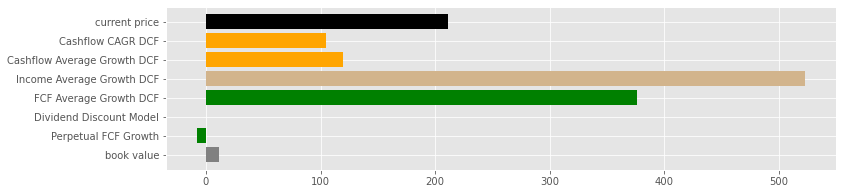

In [371]:
ax = plt.figure(figsize=(12, 3))

plt.barh("book value", book_value, color="grey")

plt.barh("Perpetual FCF Growth", PFCF_valuation, color="green")
plt.barh("Dividend Discount Model", DDM_valuation, color="skyblue")

plot_value("FCF Average Growth DCF", get_DCF_value, fcf_history, "green")
plot_value("FCF CAGR DCF", get_cagr_DCF_value, fcf_history, "green")

plot_value("Income Average Growth DCF", get_DCF_value,ic_history, "tan")
plot_value("Income CAGR DCF", get_cagr_DCF_value,ic_history, "tan")

plot_value("Cashflow Average Growth DCF", get_DCF_value,ocf_history, "orange")
plot_value("Cashflow CAGR DCF", get_cagr_DCF_value,ocf_history, "orange")

plt.barh("current price", current_price, color="black")

# Analyst's recommendations

<AxesSubplot:>

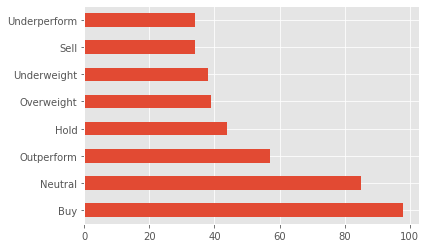

In [372]:
ticker.recommendations["To Grade"]\
    .value_counts()\
    .head(8)\
    .plot(kind="barh")

# Development area

## cashflows

In [217]:
# axis = list(df["year"])
# axis = sorted(axis)
# axis

In [218]:
# cashflow_df = df[["year","Total Cash From Operating Activities","Total Cashflows From Investing Activities", "Total Cash From Financing Activities"]]
# cashflow_df = cashflow_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
# sns.barplot("year", "amount", data=cashflow_df, hue = "cashflow", palette = ["orange", "blue", "red"], order=axis)

In [219]:
# fcf_df = df[["year","FCF", "total_debt"]]
# fcf_df = fcf_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
# sns.barplot("year", "amount", data=fcf_df, hue = "cashflow", palette = ["green", "red"], order=axis)

In [360]:
# cashflow_income= df[["year","Total Cash From Operating Activities",'Net Income Applicable To Common Shares']]
# cashflow_income = cashflow_income.melt(id_vars="year",var_name="source",value_name="amount")
# sns.barplot("year", "amount", data=cashflow_income, hue = "source", palette = ["orange", "tan"], order=axis)

## balance sheet

In [361]:
# balancesheet_prop= df[["year",'Cash', "total_debt", 'Total Assets']]
# balancesheet_prop = balancesheet_prop.melt(id_vars="year",var_name="source",value_name="amount")
# sns.barplot("year", "amount", data=balancesheet_prop, hue = "source", palette = ["green", "red", 'black', "black"], order=axis)

In [362]:
# balancesheet_df = BS[["year",'Total Stockholder Equity','Total Current Liabilities','Total Liab']]
# balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liab"] - balancesheet_df["Total Current Liabilities"] 
# balancesheet_df.drop("Total Liab",axis="columns", inplace =True)
# balancesheet_df = balancesheet_df.set_index("year").sort_index()
# balancesheet_df = balancesheet_df.div(balancesheet_df.sum(axis=1), axis=0)
# balancesheet_df.plot(kind='bar', stacked=True, color=['blue', 'brown', 'red'])

In [363]:
# ax = sns.lineplot(df["year"], df["ROE"])
# ax.invert_xaxis()
# ax.set(title="ROE")
# ax.legend()

In [364]:
# bs_ratio_df = df[["year","current_ratio", "debt_to_equity"]]
# bs_ratio_df = bs_ratio_df.melt(id_vars="year",var_name="ratio",value_name="amount")
# ax = sns.lineplot(bs_ratio_df["year"], bs_ratio_df["amount"],hue=bs_ratio_df["ratio"], palette=["blue", "red"])
# ax = sns.lineplot(bs_ratio_df["year"], 1, color = "black", linestyle="--")
# ax.invert_xaxis()
# ax.legend()

In [365]:
ticker.info.keys()

dict_keys(['zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'state', 'country', 'companyOfficers', 'website', 'maxAge', 'address1', 'industry', 'ebitdaMargins', 'profitMargins', 'grossMargins', 'operatingCashflow', 'revenueGrowth', 'operatingMargins', 'ebitda', 'targetLowPrice', 'recommendationKey', 'grossProfits', 'freeCashflow', 'targetMedianPrice', 'currentPrice', 'earningsGrowth', 'currentRatio', 'returnOnAssets', 'numberOfAnalystOpinions', 'targetMeanPrice', 'debtToEquity', 'returnOnEquity', 'targetHighPrice', 'totalCash', 'totalDebt', 'totalRevenue', 'totalCashPerShare', 'financialCurrency', 'revenuePerShare', 'quickRatio', 'recommendationMean', 'exchange', 'shortName', 'longName', 'exchangeTimezoneName', 'exchangeTimezoneShortName', 'isEsgPopulated', 'gmtOffSetMilliseconds', 'quoteType', 'symbol', 'messageBoardId', 'market', 'annualHoldingsTurnover', 'enterpriseToRevenue', 'beta3Year', 'enterpriseToEbitda', '52WeekChange', 'morningStarRiskRating', 'f